# Cumulos Abiertos: Laboratorio 2: Reducción de Imagenes
Juan David Galan Vargas - 202111470

In [64]:
from glob import glob
from astropy.io import fits
#from astropy.io import trim_image

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import pandas as pd

# statistics
from astropy.stats import biweight_location, biweight_scale, sigma_clipped_stats
from scipy.stats import median_abs_deviation

# configuration
np.set_printoptions(linewidth=120) # para que se vea
plt.rcParams["image.cmap"] = "magma" # https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.rcParams["image.origin"] = "lower"

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

# M-92, imágenes desde KPNO 

## 1) Información

Obtenga el tipo de imagen, el objeto, y después el filtro de cada una de las imágenes en la carpeta `data/m92`.

Organice esta información como crea conveniente, ya sea en diferentes variables, en diccionarios, o en un DataFrame.

¿Por qué el bias no tiene filtro asignado?

In [65]:
glob("*")

['ccd.ipynb',
 'data',
 'intensidades flats.png',
 'Laboratorio 2 Juan Galan 202111470.ipynb',
 'M92 Blue 1 Reducido por Bias y Flat.fits',
 'M92 Blue2 Reducido por Bias y Flat.fits',
 'M92 Visual 1 Reducido por Bias y Flat.fits',
 'M92 Visual 2 Reducido por Bias y Flat.fits',
 'raws bias y flats.png',
 'raws science.png',
 'Raws.png']

In [66]:
files_m92 = glob("data/m92/*.fit")
files_m92

['data/m92\\m92_1.fit',
 'data/m92\\m92_2.fit',
 'data/m92\\m92_3.fit',
 'data/m92\\m92_4.fit',
 'data/m92\\m92_5.fit',
 'data/m92\\m92_6.fit',
 'data/m92\\m92_7.fit']

In [67]:
for file in files_m92:
    print(fits.info(file))

Filename: data/m92\m92_1.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (352, 512)   int16   
None
Filename: data/m92\m92_2.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (352, 512)   int16   
None
Filename: data/m92\m92_3.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (352, 512)   int16   
None
Filename: data/m92\m92_4.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (352, 512)   int16   
None
Filename: data/m92\m92_5.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (352, 512)   int16   
None
Filename: data/m92\m92_6.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (352, 512)   int16   
None
Filename: data/m92\m92_7.fit
No.    Name

In [68]:
headers = [fits.getheader(f) for f in files_m92]
for i in range(0,7):
    print(headers[i]["OBJECT"])

ave of 25 bias
ave of  5 Harris B Sept 1 1987
ave of  5 V filter dome flat  1-sept-87
M-92 V
M-92 V
M-92 B
M-92 B


## 2) Visualización

Importe todas las imágenes con `fits.getdata`. Organice estas imágenes como considere necesario, siguendo el mismo esquema que usó en el primer punto.

Haga un subplot para visualizar todas las imágenes. Puede usar la función `quantile_imshow` que usamos para el primer laboratorio.

In [69]:
images = [fits.getdata(f) for f in files_m92]

In [70]:
def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

In [71]:
titulos = {
    '0': 'Bias',
    "1":"Flat B",
    "2":"Flat V",
    "3":"V1",
    "4":"V2",
    "5":"B1",
    "6":"B2"
    }

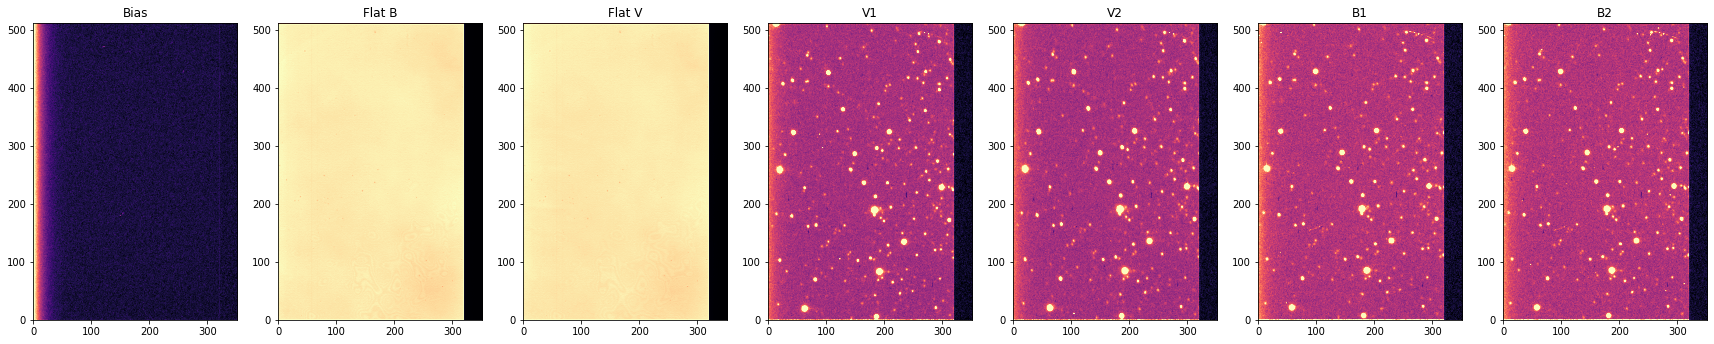

In [72]:
fig,ax = plt.subplots(ncols=7,figsize=(30,10))
for i in range(7):
    plt.sca(ax[i])
    quantile_imshow(images[i])
    plt.title(str(titulos[str(i)]))
    #plt.colorbar()

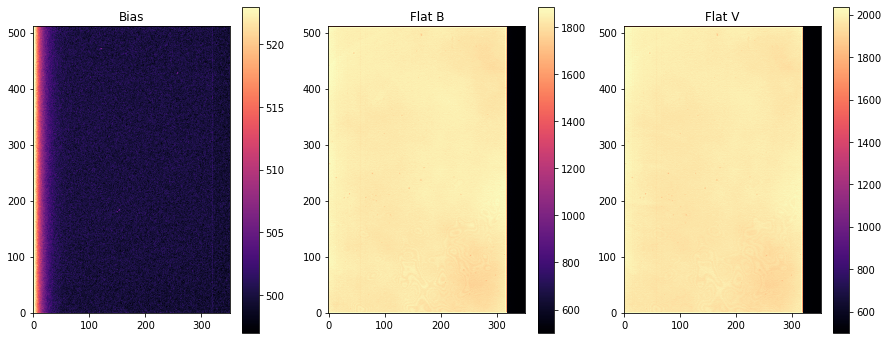

In [73]:
fig,ax = plt.subplots(ncols=3,figsize=(15,6))
for i in range(3):
    plt.sca(ax[i])
    quantile_imshow(images[i])
    plt.title(str(titulos[str(i)]))
    plt.colorbar()

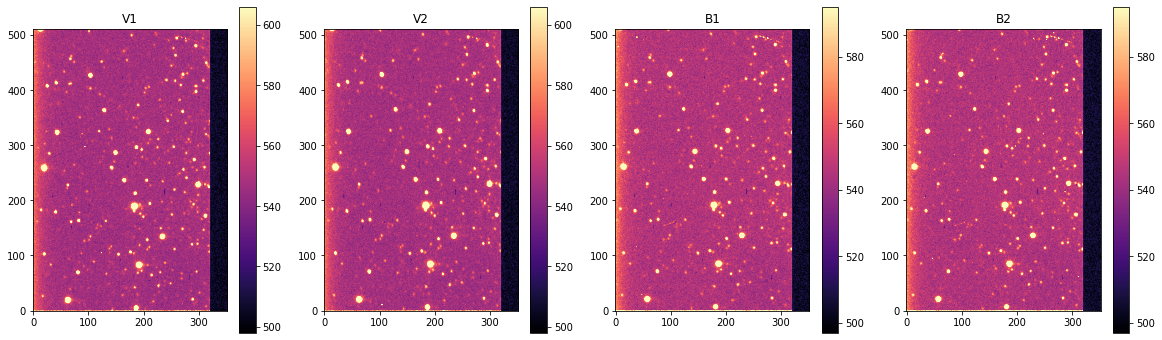

In [74]:
fig,ax = plt.subplots(ncols=4,figsize=(20,6))
for i in range(4):
    plt.sca(ax[i])
    quantile_imshow(images[i+3])
    plt.title(str(titulos[str(i+3)]))
    plt.colorbar()

## 3) Recorte

Estas imágenes tienen algo llamado _"overscan"_. Discuta brevemente qué entiende de este término, según la explicación del profesor.

### 3.A) detalle del overscan

Grafique el promedio de los pixeles en X (`np.mean(...,axis=0)`) contra los pixeles en Y (`NAXIS1`).
Haga un zoom de su gráfica de promedio a la región de overscan. Para esto puede usar `plt.xlim` y `plt.ylim`.

Determine la región de overscan: píxel inicial y pixel final. Guarde esta información como lo considere conveniente.

Obtenga estadísticas (localización y escala) de las regiones de overscan de al menos dos de las imágenes. 
¿Qué medida de localización y de escala va a usar, y por qué?

In [75]:
sum_y = [image.sum(axis=0) for image in images]
sum_x = [image.sum(axis=1) for image in images]

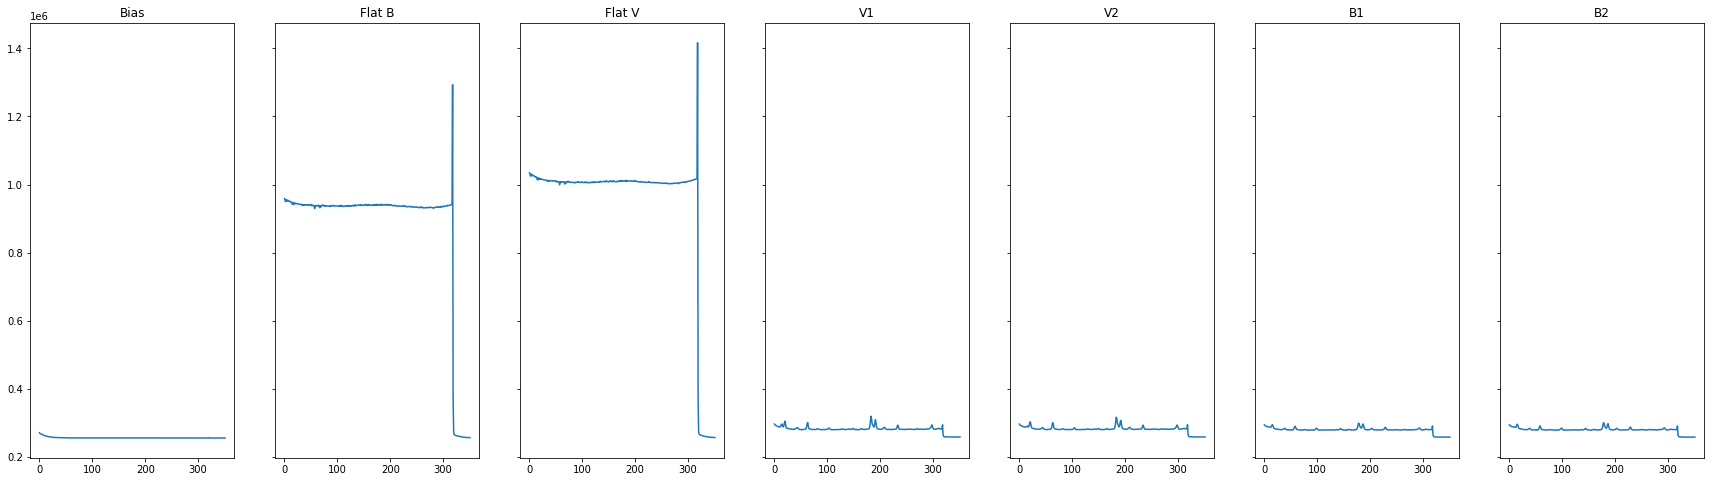

In [76]:
fig,ax = plt.subplots(ncols=7,figsize=(30,8),sharey=True)
for i in range(7):
    plt.sca(ax[i])
    plt.plot(sum_y[i])
    plt.title(str(titulos[str(i)]))

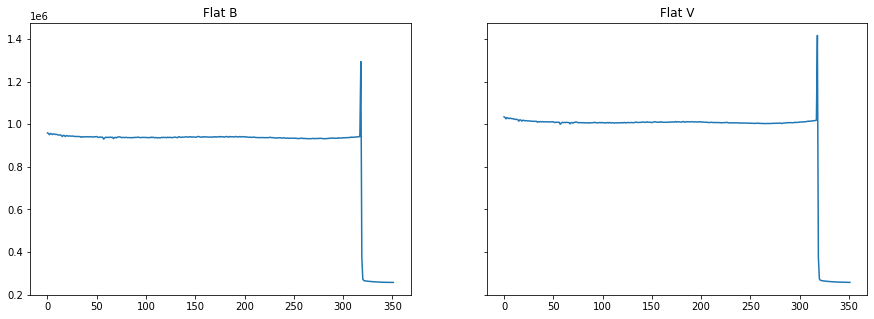

In [77]:
fig,ax = plt.subplots(ncols=2,figsize=(15,5),sharey=True)
for i in range(2):
    plt.sca(ax[i])
    plt.plot(sum_y[i+1])
    plt.title(str(titulos[str(i+1)]))

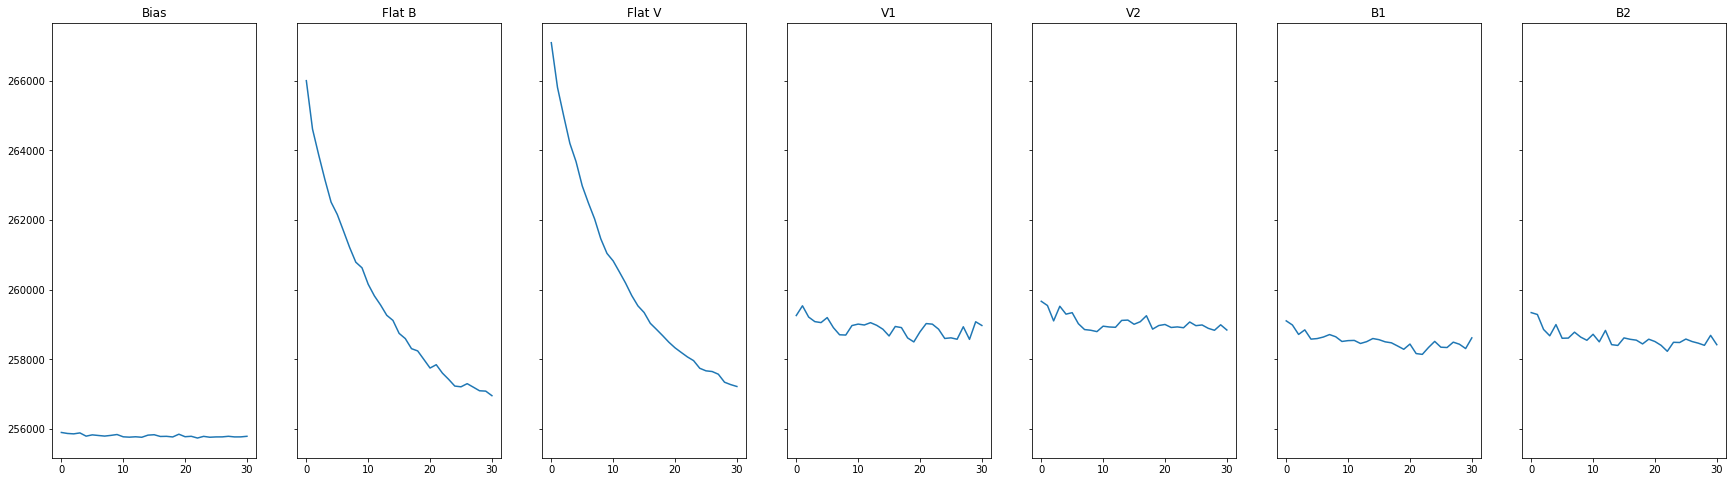

In [78]:
fig,ax = plt.subplots(ncols=7,figsize=(30,8),sharey=True)
for i in range(7):
    plt.sca(ax[i])
    plt.plot(sum_y[i][321:])
    plt.title(str(titulos[str(i)]))


In [79]:
for i in range(7):
    print("Imagen " +str(titulos[str(i)]))
    print(sum_y[i][321:].mean())
    print(np.median(sum_y[i][321:]))

Imagen Bias
255799.2258064516
255787.0
Imagen Flat B
259585.2258064516
258744.0
Imagen Flat V
260197.1935483871
259344.0
Imagen V1
258908.87096774194
258942.0
Imagen V2
259049.0
258986.0
Imagen B1
258525.70967741936
258512.0
Imagen B2
258616.87096774194
258574.0


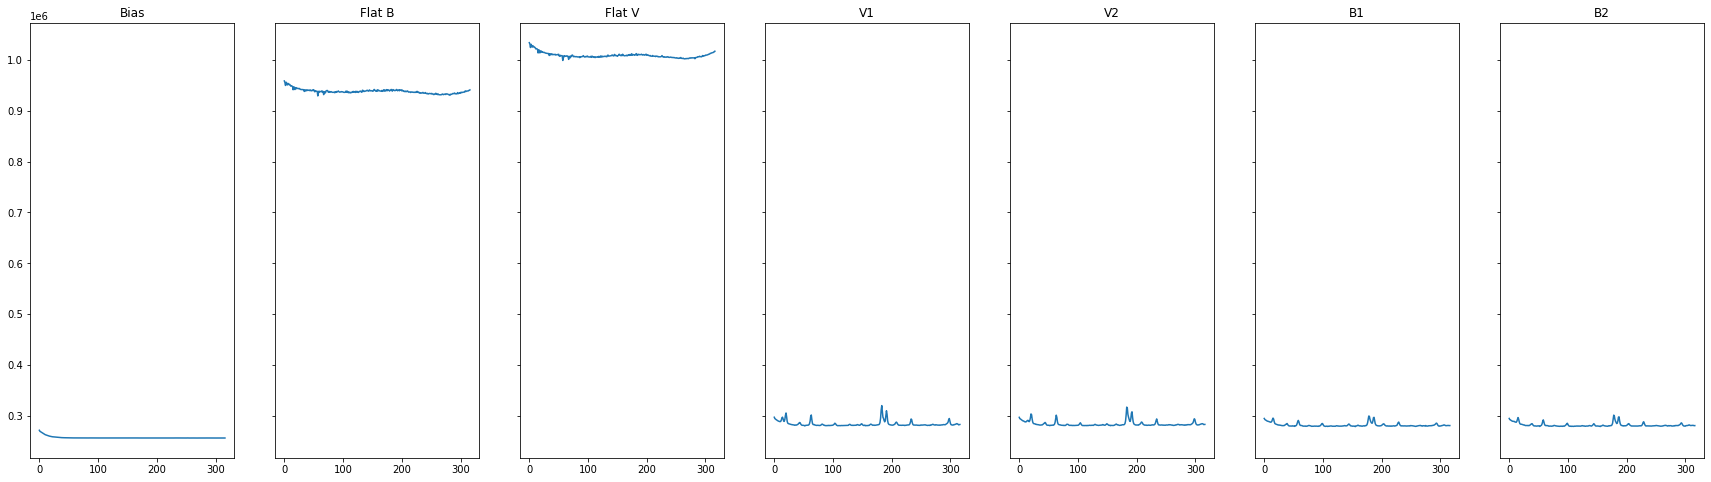

In [80]:
fig,ax = plt.subplots(ncols=7,figsize=(30,8),sharey=True)
for i in range(7):
    plt.sca(ax[i])
    plt.plot(sum_y[i][:317])
    plt.title(str(titulos[str(i)]))

In [111]:
for i in range(7):
    print("Imagen " +str(titulos[str(i)]))
    print("Media")
    print(sum_y[i][:317].mean())
    print("Mediana")
    print(np.median(sum_y[i][:317]))

Imagen Bias
Media
256594.91482649843
Mediana
256017.0
Imagen Flat B
Media
938383.4794952681
Mediana
938144.0
Imagen Flat V
Media
1009053.283911672
Mediana
1008010.0
Imagen V1
Media
283700.8895899054
Mediana
281614.0
Imagen V2
Media
283764.93375394325
Mediana
281862.0
Imagen B1
Media
281467.12933753943
Mediana
280056.0
Imagen B2
Media
281498.61514195584
Mediana
280131.0


(array([1., 0., 0., 6., 4., 4., 6., 1., 3., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 2.]),
 array([258229. , 258284.6, 258340.2, 258395.8, 258451.4, 258507. , 258562.6, 258618.2, 258673.8, 258729.4, 258785. ,
        258840.6, 258896.2, 258951.8, 259007.4, 259063. , 259118.6, 259174.2, 259229.8, 259285.4, 259341. ]),
 <BarContainer object of 20 artists>)

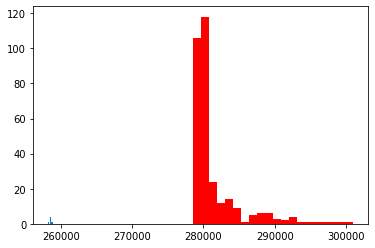

In [82]:
plt.hist(sum_y[i][:317], bins=20, color="r")
plt.hist(sum_y[i][321:], bins=20)

### 3.B) imágenes recortadas

Remueva la región de overscan (determinada en el punto anterior) de todas las imágenes. No las modifique, sino que haga copias y guarde las imágenes recortadas como considere.

In [83]:
corte=[]
for i in range (1,3):
    flat1=list(sum_y[i])
    max1=max(flat1)
    ps1 = flat1.index(max1)
    corte.append(ps1)


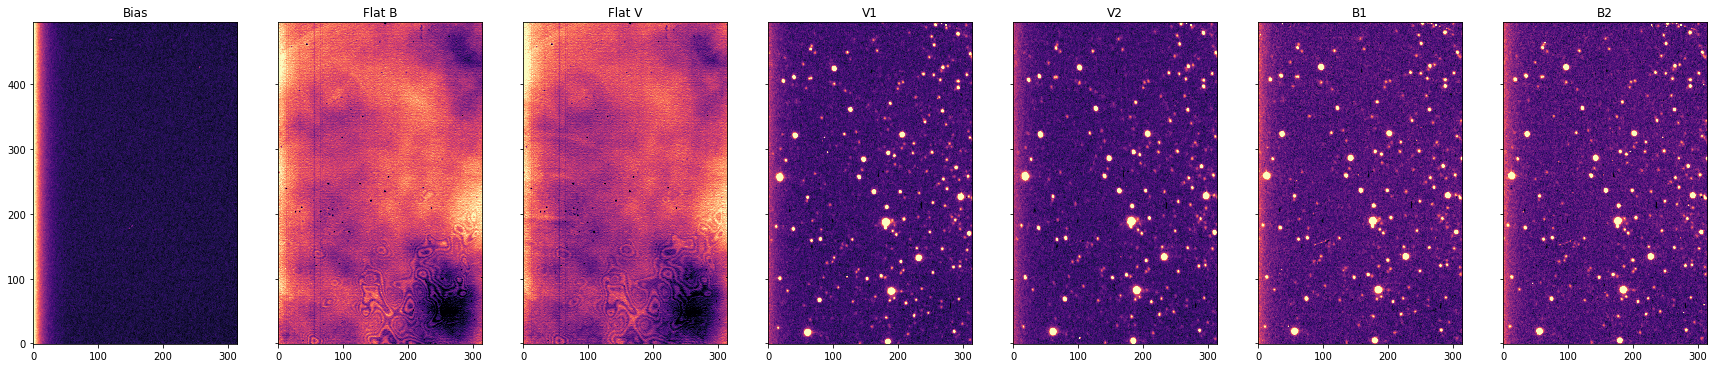

In [84]:
recortadas=[]
for i in range(7):
    trimmed = (images[i][2:498, 2:corte[0]-1])
    recortadas.append(trimmed)
for i in range(7):  
    plt.sca(ax[i])
    quantile_imshow(recortadas[i])


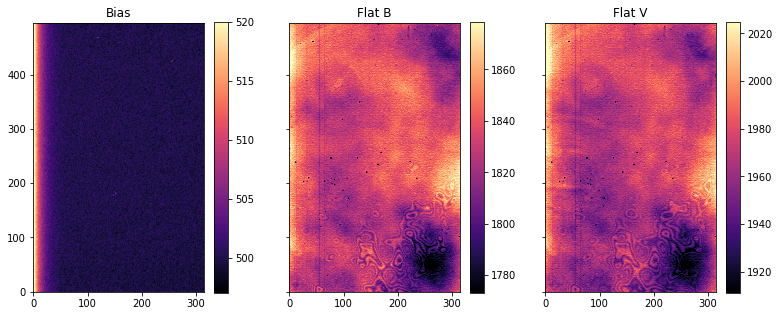

In [101]:
fig,ax = plt.subplots(ncols=3,figsize=(13,5),sharey=True)
for i in range(3):  
    plt.sca(ax[i])
    quantile_imshow(recortadas[i])
    plt.title(str(titulos[str(i)]))
    plt.colorbar()

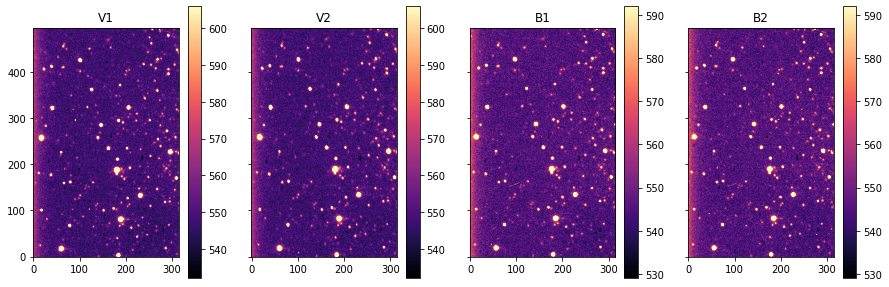

In [104]:
fig,ax = plt.subplots(ncols=4,figsize=(15,5),sharey=True)
for i in range(4):  
    plt.sca(ax[i])
    quantile_imshow(recortadas[i+3])
    plt.title(str(titulos[str(i+3)]))
    plt.colorbar()

## 4) Bias

Remueva la imagen de bias de todas las imágenes, sean flat o ciencia. De nuevo, no las modifique, haga copias, y organice como considere.

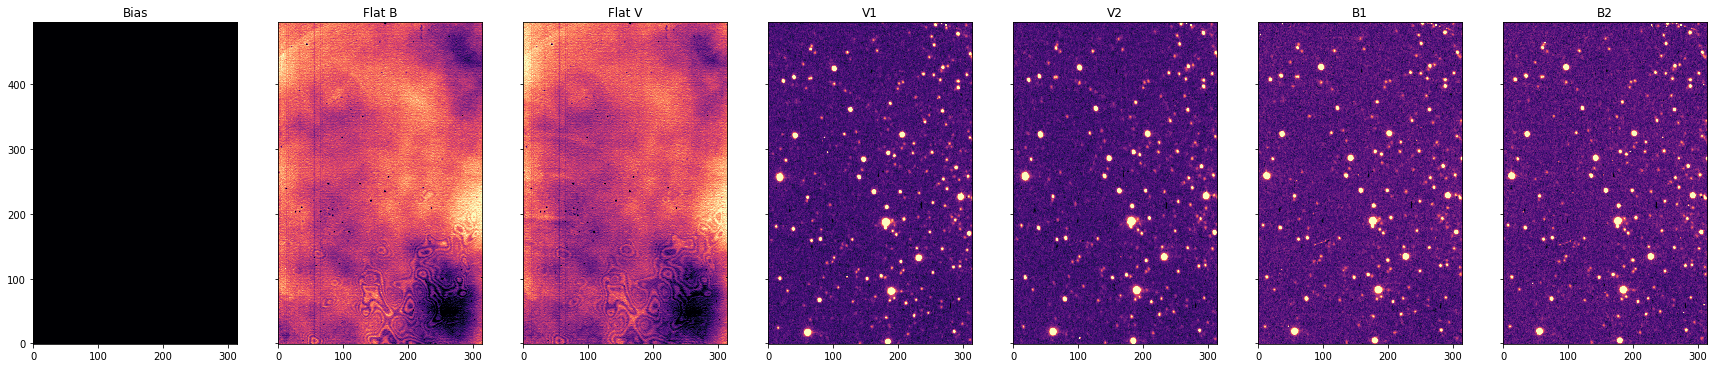

In [85]:
menos_bias=[]
for i in range(7):
    p=recortadas[i]-recortadas[0]
    menos_bias.append(p)
    plt.sca(ax[i])
    quantile_imshow(p)

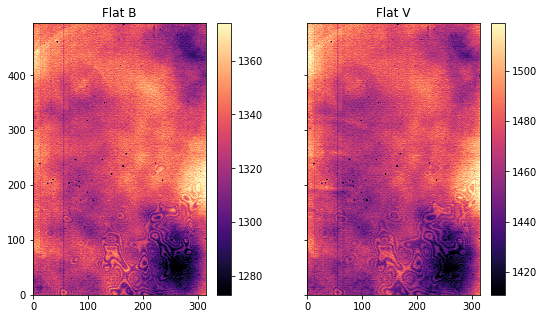

In [110]:
fig,ax = plt.subplots(ncols=2,figsize=(9,5),sharey=True)
for i in range(2):  
    plt.sca(ax[i])
    quantile_imshow(menos_bias[i+1])
    plt.title(str(titulos[str(i+1)]))
    plt.colorbar()

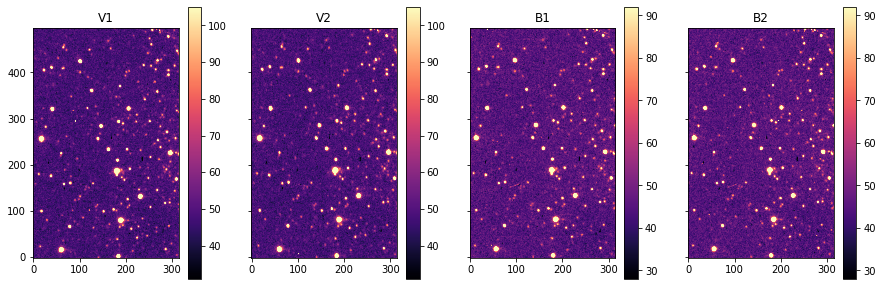

In [106]:
fig,ax = plt.subplots(ncols=4,figsize=(15,5),sharey=True)
for i in range(4):  
    plt.sca(ax[i])
    quantile_imshow(menos_bias[i+3])
    plt.title(str(titulos[str(i+3)]))
    plt.colorbar()

In [105]:
for i in range(7):
    print("Imagen " +str(titulos[str(i)]))
    print("Media")
    print(recortadas[i].mean()-menos_bias[i].mean())
    print("Mediana")
    print(np.median(recortadas[i])-np.median(menos_bias[i]))

Imagen Bias
Media
500.9894841269841
Mediana
500.0
Imagen Flat B
Media
500.9894841269843
Mediana
501.0
Imagen Flat V
Media
500.98948412698405
Mediana
501.0
Imagen V1
Media
500.9894841269841
Mediana
501.0
Imagen V2
Media
500.9894841269841
Mediana
500.0
Imagen B1
Media
500.98948412698417
Mediana
500.0
Imagen B2
Media
500.98948412698417
Mediana
500.0


### 4.extra) comparación con el overscan

Compare los valores del bias con las estádisticas que obtuvo del overscan, y comente.

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00, 8.0000e+00, 2.0000e+00,
        4.0000e+00, 2.0000e+00, 4.0000e+00, 4.0000e+00, 2.0000e+00, 4.0000e+00, 8.0000e+00, 5.0000e+00, 1.1000e+01,
        2.0000e+01, 3.6000e+01, 4.1000e+01, 1.1500e+02, 1.9100e+02, 3.6700e+02, 4.2100e+02, 6.8700e+02, 1.0350e+03,
        1.4270e+03, 1.9890e+03, 2.9450e+03, 4.0690e+03, 5.4890e+03, 7.4460e+03, 9.6580e+03, 1.1948e+04, 1.3680e+04,
        1.4842e+04, 1.5227e+04, 1.4413e+04, 1.2759e+04, 1.0720e+04, 8.52

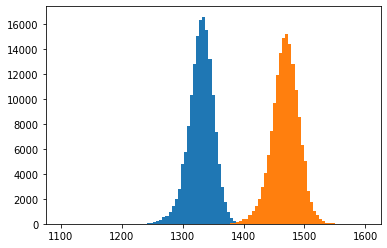

In [87]:
plt.hist(menos_bias[1].ravel(), np.linspace(1100, 1600, 100))
plt.hist(menos_bias[2].ravel(), np.linspace(1100, 1600, 100))

(array([2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 7.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00,
        2.0000e+00, 5.0000e+00, 1.0000e+00, 3.0000e+00, 7.0000e+00, 4.0000e+00, 7.0000e+00, 9.0000e+00, 1.7000e+01,
        2.5000e+01, 3.5000e+01, 5.3000e+01, 1.0600e+02, 1.6400e+02, 2.1800e+02, 3.1500e+02, 3.6500e+02, 5.7700e+02,
        8.0300e+02, 1.0120e+03, 1.4010e+03, 1.7370e+03, 2.4430e+03, 4.0690e+03, 4.2430e+03, 5.4820e+03, 6.8240e+03,
        8.2120e+03, 9.7800e+03, 1.0874e+04, 1.1597e+04, 1.2238e+04, 1.2074e+04, 1.1379e+04, 1.0396e+04, 9.0880e+03,
        7.6450e+03, 6.2850e+03, 4.9020e+03, 3.6420e+03, 2.6010e+03, 1.8500e+03, 1.2700e+03, 8.5700e+02, 6.0000e+02,
        3.9900e+02, 2.7000e+02, 1.3600e+02, 8.1000e+01, 5.0000e+01, 1.9000e+01, 1.4000e+01, 8.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

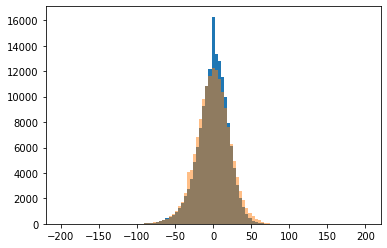

In [97]:
normalizado1_bias=menos_bias[1].ravel()-menos_bias[1].ravel().mean()
normalizado2_bias=menos_bias[2].ravel()-menos_bias[2].ravel().mean()
plt.hist(normalizado1_bias, np.linspace(-200, 200, 100))
plt.hist(normalizado2_bias, np.linspace(-200, 200, 100),alpha=0.5)

## 5) Flat

Normalice las imágenes flat (de nuevo, ¿qué medida de localización va a usar, y por qué?), y aplique el flat a las imágenes ciencia, teniendo cuidado de usar el filtro apropiado.

In [93]:
FlatB_norm=menos_bias[1]/np.mean(menos_bias[1])
FlatV_norm=menos_bias[2]/np.mean(menos_bias[2])

V1= menos_bias[3]/FlatV_norm
V2= menos_bias[4]/FlatV_norm
B1=menos_bias[5]/FlatB_norm
B2=menos_bias[6]/FlatB_norm
procesadas=[V1,V2,B1,B2]


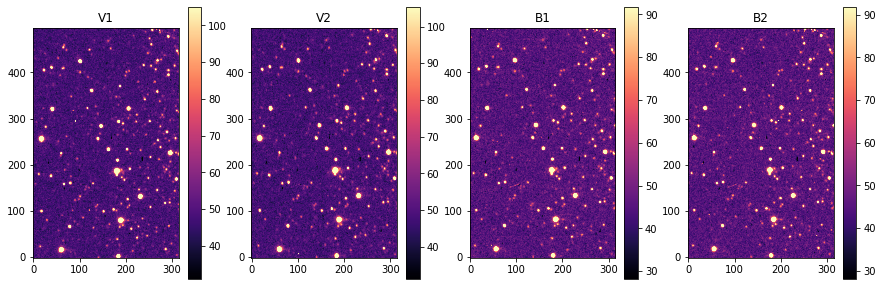

In [94]:
fig,ax = plt.subplots(ncols=4,figsize=(15,5))
for i in range(4):
    plt.sca(ax[i])
    quantile_imshow(procesadas[i])
    plt.title(str(titulos[str(i+3)]))
    plt.colorbar()

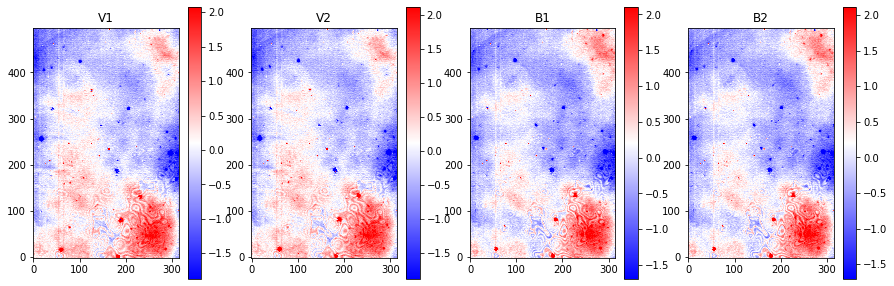

In [112]:
fig,ax = plt.subplots(ncols=4,figsize=(15,5))
for i in range(4):
    plt.sca(ax[i])
    quantile_imshow(procesadas[i] - menos_bias[i+3],cmap="bwr")
    plt.title(str(titulos[str(i+3)]))
    plt.colorbar()
    

## 6) Guardar las imágenes calibradas

Primero, copie los headers originales de las imágenes ciencia, y agregue un comentario describiendo **_muy brevemente_** el proceso de reducción realizado.

Para guardar sus resultados en formato fits, para cada imagen ciencia calibrada, use la función `fits.PrimaryHDU`. 
Use los headers que contienen su comentario.

Una vez obtenido el objeto `PrimaryHDU`, use el método `hdu.writeto`. Ponga un nombre descriptivo, pero corto, a las imágenes resultantes.

In [32]:
headV11= headers[3]
comentario= "se realizo la reduccion de las imagenes ciencia del cumulo globular m92. Posteriormente a los Raws se resto el efecto del Bias, luego se normalizo el efecto de los Flats y finalmente se obtuvo las imagenes ciencia a partir del cociente entre los Raws-bias y los Flats normalizados"
headV11['HISTORY'] =comentario

In [33]:
headv2 = headers[4]
headv2["HISTORY"]= comentario


In [34]:
headb1 = headers[5]
headb1["HISTORY"]= comentario
headb2 = headers[6]
headb2["HISTORY"]=comentario

In [35]:
print(headV11["HISTORY"])
print(headv2["HISTORY"])
print(headb1["HISTORY"])
print(headb2["HISTORY"])


'KPNO-IRAF'  /
'13-01-92'  /
New copy of /u2/jacoby/m92010.imh
New copy of ursa!/u2/jbarnes/iraf/m92/m92010.imh
se realizo la reduccion de las imagenes ciencia del cumulo globular m92.
 Posteriormente a los Raws se resto el efecto del Bias, luego se normali
zo el efecto de los Flats y finalmente se obtuvo las imagenes ciencia a
partir del cociente entre los Raws-bias y los Flats normalizados
'KPNO-IRAF'  /
'13-01-92'  /
New copy of /u2/jacoby/m92011.imh
New copy of ursa!/u2/jbarnes/iraf/m92/m92011.imh
se realizo la reduccion de las imagenes ciencia del cumulo globular m92.
 Posteriormente a los Raws se resto el efecto del Bias, luego se normali
zo el efecto de los Flats y finalmente se obtuvo las imagenes ciencia a
partir del cociente entre los Raws-bias y los Flats normalizados
'KPNO-IRAF'  /
'13-01-92'  /
New copy of /u2/jacoby/m92014.imh
New copy of ursa!/u2/jbarnes/iraf/m92/m92014.imh
se realizo la reduccion de las imagenes ciencia del cumulo globular m92.
 Posteriormente a los Raw

In [92]:
visual1= fits.PrimaryHDU(V1, headV11)
visual2= fits.PrimaryHDU(V2, headv2)
blue1= fits.PrimaryHDU(B1, headb1)
blue2= fits.PrimaryHDU(B2, headb2)
visual1.writeto("M92 Visual 1 Reducido por Bias y Flat")
visual2.writeto("M92 Visual 2 Reducido por Bias y Flat")
blue1.writeto("M92 Blue 1 Reducido por Bias y Flat")
blue2.writeto("M92 Blue2 Reducido por Bias y Flat") #Notese que es necesario agregar al nombre del archivo ".fits" para que quede en este formato tal que se pueda abrir en un software como ImageJ